In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error 
np.random.seed(42)
warnings.filterwarnings('ignore')

### 3.1 Simulating the Random Walk Process

In [3]:
steps = np.random.standard_normal(1000)       
steps[0] = 0
random_walk = np.cumsum(steps) 

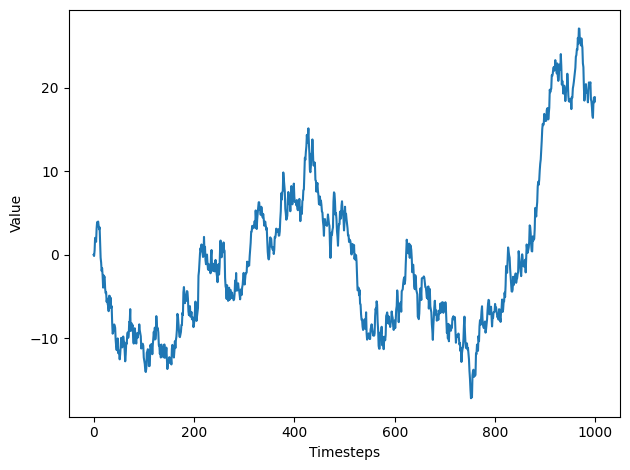

In [4]:
fig, ax = plt.subplots()
 
ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
 
plt.tight_layout()

### 3.2 Defining the Random Walk

A random walk is a series whose first difference is stationary and uncorrelated.

#### Stationarity 
Use differencing to create a stationary time series.  
Use the Augmented Dicker-Fuller test to examine stationarity.  
Null hypothesis: a unit root is present => the time series is not stationary.  
More negative ADF statistic & smaller p-value => stronger rejection of the null hypothesis  

#### The Auto Correlation Function
The autocorrelation function (ACF) measures the linear relationship between lagged values of a time series.

#### Is random walk a stationary process?

In [5]:
# p-value > 0.05, cannot reject the null hypothesis that it's not stationary.
result = adfuller(random_walk)
print(f'p-value: {result[1]}')

p-value: 0.7654789696692579


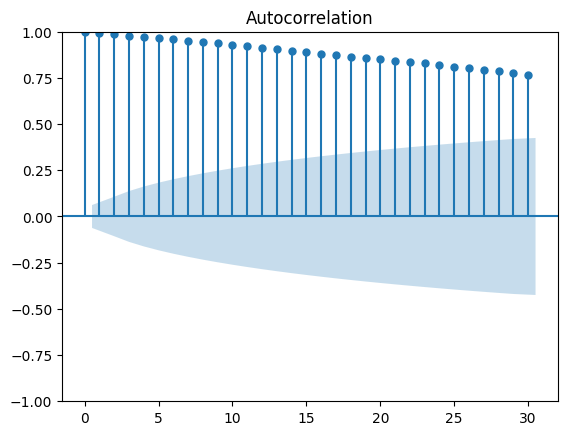

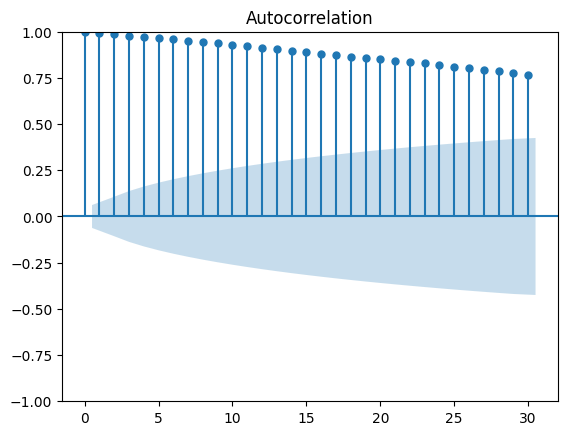

In [6]:
plot_acf(random_walk)

In [7]:
diff_random_walk = np.diff(random_walk, n=1)
result = adfuller(diff_random_walk)
print(f'p-value: {result[1]}')

p-value: 0.0


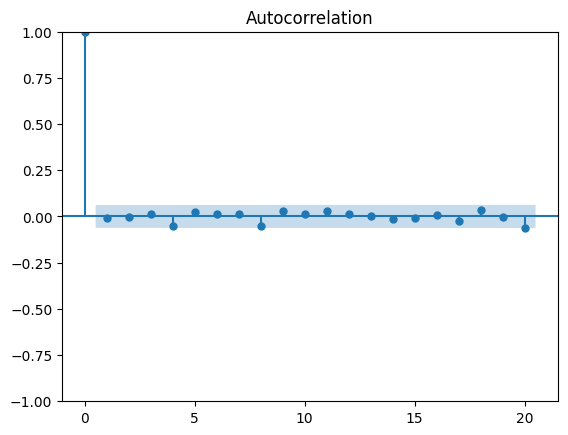

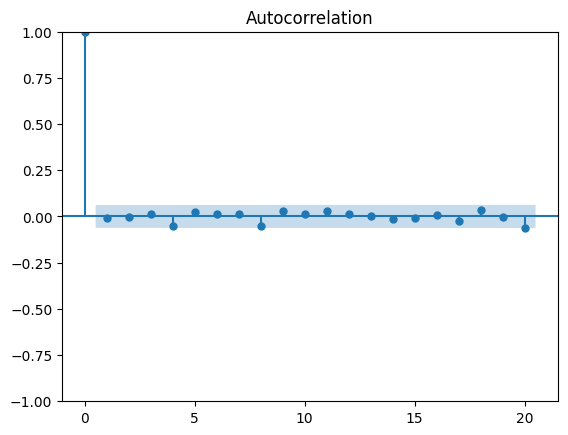

In [8]:
plot_acf(diff_random_walk, lags=20)

Is Google a random walk?

In [9]:
df = pd.read_csv('./data/GOOGL.csv')

google_adf_result = adfuller(df['Close'])

print(f'ADF Statistic: {google_adf_result[0]}')
print(f'p-value: {google_adf_result[1]}')

ADF Statistic: 0.1602504866477152
p-value: 0.9699419435913058


In [10]:
diff_close = np.diff(df['Close'], n=1)
diff_google_adf_result = adfuller(diff_close)

print(f'ADF Statistic: {diff_google_adf_result[0]}')
print(f'p-value: {diff_google_adf_result[1]}')

ADF Statistic: -5.30343970429522
p-value: 5.386530961454919e-06


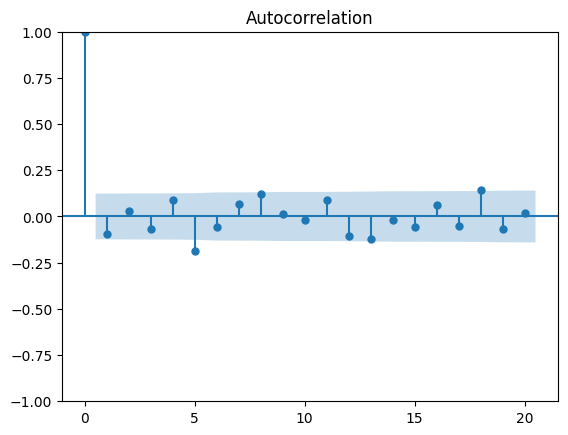

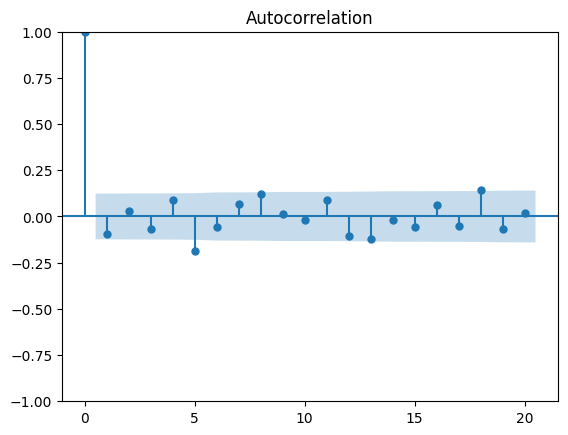

In [11]:
plot_acf(diff_close, lags=20)

### 3.3 Forecasting a random walk
#### 3.3.1 Forcasting on a long horizon
The conculsion: It just doesn't make sense to predict a long horizon of a random walk.

In [12]:
df = pd.DataFrame({'value': random_walk})
 
train = df[:800]
test = df[800:]

We can predict the future using historical mean.

In [13]:
mean = np.mean(train.value)
test.loc[:, 'pred_mean'] = mean
test.head()

,value,pred_mean
800,-5.876664,-3.677206
801,-6.392708,-3.677206
802,-6.296588,-3.677206
803,-6.758863,-3.677206
804,-7.193359,-3.677206


We can predict the future using the last value.

In [14]:
last_value = train.iloc[-1].value
test.loc[:, 'pred_last'] = last_value
test.head()

,value,pred_mean,pred_last
800,-5.876664,-3.677206,-6.814947
801,-6.392708,-3.677206,-6.814947
802,-6.296588,-3.677206,-6.814947
803,-6.758863,-3.677206,-6.814947
804,-7.193359,-3.677206,-6.814947


We can also predict the future by extrapolating the slope.

In [15]:
deltaX = 800 - 1            
deltaY = last_value - 0    
drift = deltaY / deltaX
 
x_vals = np.arange(800, 1000, 1)
pred_drift = drift * x_vals
test.loc[:, 'pred_drift'] = pred_drift

test.head()

,value,pred_mean,pred_last,pred_drift
800,-5.876664,-3.677206,-6.814947,-6.823477
801,-6.392708,-3.677206,-6.814947,-6.832006
802,-6.296588,-3.677206,-6.814947,-6.840536
803,-6.758863,-3.677206,-6.814947,-6.849065
804,-7.193359,-3.677206,-6.814947,-6.857594


We can visualize these three methods. As shown on the chart, all of them are faulty.

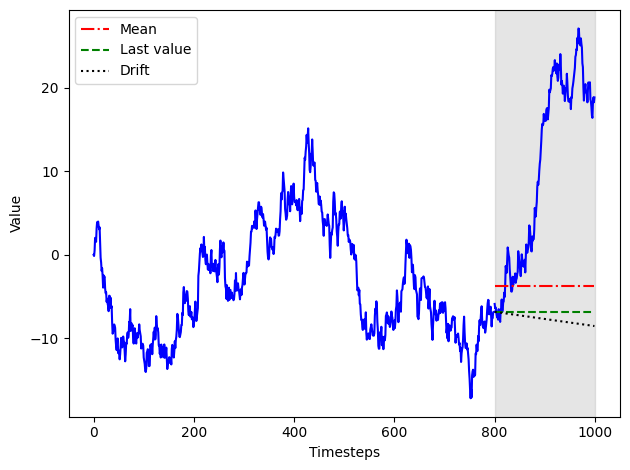

In [16]:
fig, ax = plt.subplots()
 
ax.plot(train.value, 'b-')                                
ax.plot(test['value'], 'b-')                              
ax.plot(test['pred_mean'], 'r-.', label='Mean')           
ax.plot(test['pred_last'], 'g--', label='Last value')     
ax.plot(test['pred_drift'], 'k:', label='Drift')          

ax.axvspan(800, 1000, color='#808080', alpha=0.2)         
ax.legend(loc=2)                                          
 
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

We can see that the best prediction is to use the historical mean, but the MSE is over 300 and still very high.

In [18]:
for pred_column in ['pred_mean', 'pred_last', 'pred_drift']:
    print(f'{pred_column} mean square error: ', mean_squared_error(test['value'], test[pred_column]))

pred_mean mean square error:  326.50277395297474
pred_last mean square error:  425.1726033055617
pred_drift mean square error:  465.9076036601397
